# RNN用于时间序列的分析

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
data_csv=pd.read_csv('./data.csv',usecols=[1])
data_csv2=pd.read_csv('./data.csv')

In [7]:
# print(data_csv)
print(data_csv2.columns)
# plt.plot(data_csv)

Index(['Month', 'International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60'], dtype='object')


In [43]:
#首先我们进行预处理，将数据中 na 的数据去掉，然后将数据标准化到 0 ~ 1 之间。
data_csv=data_csv.dropna()
dataset=data_csv.values #[[num1][num2]...]是numpy类型
dataset=dataset.astype('float32')
max_value=np.max(dataset)
min_value=np.min(dataset)
scalar=max_value-min_value
dataset=list(map(lambda x:x/scalar, dataset))

In [44]:
print(dataset)

[array([0.21621622], dtype=float32), array([0.22779922], dtype=float32), array([0.25482625], dtype=float32), array([0.24903475], dtype=float32), array([0.23359074], dtype=float32), array([0.26061776], dtype=float32), array([0.2857143], dtype=float32), array([0.2857143], dtype=float32), array([0.26254827], dtype=float32), array([0.22972973], dtype=float32), array([0.2007722], dtype=float32), array([0.22779922], dtype=float32), array([0.22200772], dtype=float32), array([0.24324325], dtype=float32), array([0.27220076], dtype=float32), array([0.26061776], dtype=float32), array([0.24131274], dtype=float32), array([0.28764477], dtype=float32), array([0.32818532], dtype=float32), array([0.32818532], dtype=float32), array([0.30501932], dtype=float32), array([0.25675675], dtype=float32), array([0.22007722], dtype=float32), array([0.27027026], dtype=float32), array([0.27992278], dtype=float32), array([0.28957528], dtype=float32), array([0.34362933], dtype=float32), array([0.3146718], dtype=float

In [45]:
def create_dataset(dataset,look_back=2):
    dataX,dataY=[],[]
    for i in range(len(dataset)-look_back):
        a=dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i+look_back])
    return np.array(dataX),np.array(dataY)

In [46]:
data_X,data_Y=create_dataset(dataset)

In [47]:
# 划分训练集和测试集，70% 作为训练集
train_size=int(len(data_X)*0.7)
test_size=len(data_X)-train_size
train_X=data_X[:train_size]
train_Y=data_Y[:train_size]
test_X=data_X[train_size:]
test_Y=data_Y[train_size:]

In [48]:
#最后，我们需要将数据改变一下形状，因为 RNN 读入的数据维度是 (seq, batch, feature)，所以要重新改变一下数据的维度.
#这里只有一个序列，所以 batch 是 1，而输入的 feature 就是我们希望依据的几个月份，这里我们定的是两个月份，所以 feature 就是 2.
import torch
train_X=train_X.reshape(-1,1,2)
train_Y=train_Y.reshape(-1,1,1)
test_X=test_X.reshape(-1,1,2)

train_x=torch.from_numpy(train_X)
train_y = torch.from_numpy(train_Y)
test_x = torch.from_numpy(test_X)

In [49]:
print(train_X.shape)
print(train_Y.shape)

(99, 1, 2)
(99, 1, 1)


In [50]:
from torch import nn
from torch.autograd import Variable

In [51]:
class lstm_reg(nn.Module):
    def __init__(self,input_size,hidden_size,output_size=1,num_layers=2):
        super(lstm_reg,self).__init__()
        self.rnn=nn.LSTM(input_size,hidden_size,num_layers)#rnn
        self.reg=nn.Linear(hidden_size,output_size) # 回归
    def forward(self,x):
        x,_=self.rnn(x)
        s,b,h=x.shape
        x=x.view(s*b,h)#tensor.view()是reshape的作用
        x=self.reg(x)
        x=x.view(s,b,-1)
        return x

In [52]:
net=lstm_reg(2,4)
criterion=nn.MSELoss()
optimizer=torch.optim.Adam(net.parameters(),lr=1e-2)

In [53]:
#定义好网络结构，输入的维度是 2，因为我们使用两个月的流量作为输入，隐藏层的维度可以任意指定，这里我们选的 4
for e in range(1000):
    var_x=Variable(train_x)
    var_y=Variable(train_y)
    #前向传播
    out=net(var_x)
    loss=criterion(out,var_y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (e+1)%100==0:
        print('Epoch:{},Loss:{:.5f}'.format(e+1,loss.item()))

Epoch:100,Loss:0.00407
Epoch:200,Loss:0.00390
Epoch:300,Loss:0.00373
Epoch:400,Loss:0.00350
Epoch:500,Loss:0.00316
Epoch:600,Loss:0.00281
Epoch:700,Loss:0.00194
Epoch:800,Loss:0.00125
Epoch:900,Loss:0.00112
Epoch:1000,Loss:0.00123


In [54]:
net=net.eval()

In [55]:
data_X=data_X.reshape(-1,1,2)
data_X=torch.from_numpy(data_X)
var_data=Variable(data_X)
pred_test=net(var_data)

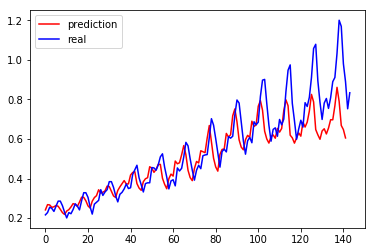

In [56]:
# 改变输出的格式
pred_test = pred_test.view(-1).data.numpy()
# 画出实际结果和预测的结果
plt.plot(pred_test, 'r', label='prediction')
plt.plot(dataset, 'b', label='real')
plt.legend(loc='best')

### 小结:
- `tensor=tensor.view(new_shape)`:相当于tensorflow中的tensor.reshape()
- `pandas.read_csv(file)`:返回一个DataFrame的对象
- `csvObject.columns`:dataFrame查看字段名称
- `csvObject['column']`:查看某个字段